# Home Credit Modeling 

### Table of Contents
 * [Set up](#setup)
     * [Data Acquisition](#acq)
     * [Preliminary Functions and Data Preparation](#pre-lim-functions)
     * [Key Variables](#key-vars)
 * [Introduction](#intro)
     * [Project Goal](#proj-goal)
     * [Business Problem](#business-problem)
     * [Analytic Problems](#a-prob)
 * [Modeling Process](#mod-proc)
     * [Models Considered](#mods-con)
     * [Final Model](#fin-mod)
         * [Normal XGBoost 1](#nxg_1)
         * [Normal XGBoost 2](#nxg_2)
         * [SMOTE XGBoost 1](#sxg_1)
         * [SMOTE XGBoost 2](#sxg_2)
 * [Model Performance](#model_performance)
 * [Results](#results)


## Set up <a class="anchor" id="setup"></a>

In [1]:
#Get the different packages that might be used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
#!pip install opendatasets
import opendatasets as od
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from xgboost import cv
#!pip install imblearn
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE

### Data Acquisition <a class="anchor" id="acq"></a>

In [2]:
#Get the data #Make sure that your kaggle.json file is in the working directory
od.download("https://www.kaggle.com/competitions/home-credit-default-risk/data")

Skipping, found downloaded files in "./home-credit-default-risk" (use force=True to force download)


In [3]:
#Get the working directory for file extraction
current_working_directory = os.getcwd()

In [4]:
#Get the required datasets
test_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/application_test.csv")
train_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/application_train.csv")
previous_application_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/previous_application.csv")
bureau_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/bureau.csv")

In [5]:
#Create full datasets for exploration
all_the_data = pd.concat([test_data, train_data], axis = 0)
main_data_joined_prevapp = all_the_data.merge(previous_application_data, on = "SK_ID_CURR", how = "left")

### Preliminary Functions and Data Preparation <a class="anchor" id="pre-lim-functions"></a>

The functions below provide a modular framework that makes it easy to replicate the transformations done in the future. Three main tables were used. The first, the application table, had all categorical columns coded with a one hot encoder designed by Kaggle user Aguiar (the link is in that respective cell). Those columns that were binary but were not set as 1s and 0s were factorized. In the previous application table, a count of the amount of times a current current shows up in there is compared to the amount of applications that were rejeted. This gives us a percentage of their previous applications that were rejected. Lastly, the bureau data is added on and cleaned. These data underwent similar transforms to the previous application data but instead the percentage and count of overdue loans are counted for each customer. In general, when it was needed, NaNs were imputed as the mean of the column. Furthermore, missing data was removed entirely. If a column was missing more than 40% of its data, it was removed. 

Of the variables that were left, only variables with a larger relative magnitude of correlation with the target were kept for use in the training of the model.

In [6]:
# One-hot encoding for categorical columns with get_dummies#Borrowed from Aguiar https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
#Create function for cleaning the first table. Parts also inspired by above source.
def clean_application_train_test(test_data = test_data, train_data = train_data,all_the_data = all_the_data,nan_as_category=False):
    # Make the full dataframe for cleaning
    app_tt_all = all_the_data
    #Get these columns in correct format asthey are not 1s and 0s
    for column in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        app_tt_all[column], uniques = pd.factorize(app_tt_all[column])
    # Categorical features with dummies from above
    ap_tt_all, cat_columns = one_hot_encoder(app_tt_all, nan_as_category)
    app_tt_all = pd.DataFrame(app_tt_all)
    return app_tt_all


In [8]:
def clean_previous_application(previous_application_data = previous_application_data):
    #To partition out the data
    previous_application_data.loc[previous_application_data['NAME_CONTRACT_STATUS']=='Approved','NAME_CONTRACT_STATUS'] = 1
    previous_application_data.loc[previous_application_data['NAME_CONTRACT_STATUS']!= 1,'NAME_CONTRACT_STATUS'] = 0
    
    #The joined data creates duplicates as it seems like some people have multiple previous apps. Seeing if I can get a count of those
    skid_counts_prev = pd.DataFrame(previous_application_data.SK_ID_CURR.value_counts())
    skid_counts_prev.rename(columns={skid_counts_prev.columns[0]: 'COUNT'},inplace=True)
    skid_counts_prev.index.name = 'SK_ID_CURR'
    
    #Create the counts of approved
    skid_counts_prev_approved = pd.DataFrame(previous_application_data[previous_application_data['NAME_CONTRACT_STATUS']==1].groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].count())
    
    #Create the dataframe that is the amount of previous with approved.
    skid_counts_prev_approved = skid_counts_prev.merge(skid_counts_prev_approved, on = "SK_ID_CURR", how = "left")
    skid_counts_prev_approved.loc[skid_counts_prev_approved["NAME_CONTRACT_STATUS"].isna(),"NAME_CONTRACT_STATUS"] = 0 #To make sure we capture those that did not get approved.
    
    # Getting the percentage
    skid_counts_prev_approved['Approval_Perc'] = skid_counts_prev_approved['NAME_CONTRACT_STATUS']/skid_counts_prev_approved['COUNT']
    
    #Prepare data for joining to main test and train to use these features
    skid_counts_prev_approved.rename(columns={'COUNT': 'NUM_PREV_APPLICATIONS',
                                          'NAME_CONTRACT_STATUS': 'NUM_PREV_APPLICATIONS_APPROVED',
                                          'Approval_Perc': 'PREV_APP_APPROVAL_PERC'},inplace=True)
    
    skid_counts_prev_approved = pd.DataFrame(skid_counts_prev_approved)
    return skid_counts_prev_approved

In [9]:
def clean_bureau(bureau_data = bureau_data):
    #To partition out the data
    previous_application_data.loc[previous_application_data['NAME_CONTRACT_STATUS']=='Approved','NAME_CONTRACT_STATUS'] = 1
    previous_application_data.loc[previous_application_data['NAME_CONTRACT_STATUS']!= 1,'NAME_CONTRACT_STATUS'] = 0
    
    #The joined data creates duplicates as it seems like some people have multiple previous bureau reports. Seeing if I can get a count of those
    skid_counts_bureau = pd.DataFrame(bureau_data.SK_ID_CURR.value_counts())
    skid_counts_bureau.rename(columns={skid_counts_bureau.columns[0]: 'COUNT'},inplace=True)
    skid_counts_bureau.index.name = 'SK_ID_CURR'
    
    #Create the counts of overdue
    skid_counts_bureau_overdue = pd.DataFrame(bureau_data[bureau_data['CREDIT_DAY_OVERDUE']!=0].groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].count())
    
    #Create the dataframe that is the amount of previous with overdue.
    skid_counts_bureau = skid_counts_bureau.merge(skid_counts_bureau_overdue, on = "SK_ID_CURR", how = "left")
    skid_counts_bureau.loc[skid_counts_bureau["CREDIT_DAY_OVERDUE"].isna(),"CREDIT_DAY_OVERDUE"] = 0 #To make sure we capture those that did not get approved.
    
    # Getting the percentage
    skid_counts_bureau['OVERDUE_PERCENTAGE'] = skid_counts_bureau['CREDIT_DAY_OVERDUE']/skid_counts_bureau['COUNT']
    
    #Prepare data for joining to main test and train to use these features
    skid_counts_bureau.rename(columns={'COUNT': 'NUM_BUREAU_REPORTS',
                                          'CREDIT_DAY_OVERDUE': 'NUM_BUREAU_REPORTS_OVERDUE',
                                          'OVERDUE_PERCENTAGE': 'OVERDUE_PERCENTAGE'},inplace=True)
    
    skid_counts_bureau = pd.DataFrame(skid_counts_bureau)
    return skid_counts_bureau

In [10]:
def make_the_needed_dataframes_for_training(missing_data_thresh = 40, corr_thresh = .01, test_size = .15):
    
    #Clean application train and test
    application_train_test_clean = clean_application_train_test()
    
    #Clean previous app and get what we want from it
    previous_application_useful_clean = clean_previous_application()
    
    #Clean bureau
    bureau_useful_clean = clean_bureau()
    
    #Combine the three and check for duplicates
    
    app_prev = application_train_test_clean.merge(previous_application_useful_clean, on = "SK_ID_CURR", how = "left")
    app_prev = app_prev.merge(bureau_useful_clean, on = "SK_ID_CURR", how = "left")
    
    if app_prev.duplicated(subset=["SK_ID_CURR"]).any() == False: #The code before the .any() looks at the column "SK_ID_CURR" and checks to see if there are any duplicates. This returns a column that is a boolean. The .any() is looking to see if any of those are True.
        pass
    else:
        raise DuplicateError("There are duplicates in the combined dataset.")
    
    #Check to see how much data is missing to just get rid of it
    #Sum all the nulls and divide by number of rows to get percentage
    main_data_joined_prevapp_perc_missing = pd.DataFrame(round(app_prev.isnull().sum()/app_prev.shape[0]*100,2))
    #Name this output to assist in code below
    main_data_joined_prevapp_perc_missing.columns = ['missing']
    #Remove all the columns with the missing data above 40.
    main_data_joined_prevapp_perc_missing = main_data_joined_prevapp_perc_missing[main_data_joined_prevapp_perc_missing['missing']<(100-missing_data_thresh)]
    #Get the columns that are kept
    #Columns that have more than 60% of their data
    main_data_joined_prevapp_perc_60more = main_data_joined_prevapp_perc_missing.T.columns
    #Remove the columns that have less than 60% of their data
    app_prev = app_prev[main_data_joined_prevapp_perc_60more]
    #Print('removing these columns as they lack the data')
    
    #Look at correlations
    #Create the df of all the correlations with the new features
    add_corr_df2 = pd.DataFrame(app_prev.corr())
    #Reduce the df to show only corr with the target
    add_corr_df2 = pd.DataFrame(add_corr_df2["TARGET"])
    #Name the columns
    add_corr_df2.columns = ["Correlation w/ Target"]
    
    #Keep those that are most correlated
    add_corr_df2_import = add_corr_df2[(add_corr_df2['Correlation w/ Target'] > corr_thresh)| (add_corr_df2['Correlation w/ Target'] < -corr_thresh)].sort_values("Correlation w/ Target")
    columns_to_keep = add_corr_df2_import.T.columns
    columns_to_keep = list(columns_to_keep)
    columns_to_keep.append('SK_ID_CURR')
    
    print('The columns that are being kept are:',columns_to_keep)
    
    app_prev = app_prev[columns_to_keep]
    
    #Seperate back into train and test
    train_data_clean = app_prev[app_prev['SK_ID_CURR'].isin(train_data['SK_ID_CURR'])]
    test_data_clean = app_prev[app_prev['SK_ID_CURR'].isin(test_data['SK_ID_CURR'])]
    train_data_clean = train_data_clean.set_index('SK_ID_CURR')
    test_data_clean = test_data_clean.set_index('SK_ID_CURR')
    test_data_clean.drop('TARGET', axis = 1)
    
    #Make the Xs and ys for training (from the training set)
    global X, y
    X=train_data_clean.drop('TARGET', axis=1)
    y=train_data_clean['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=test_size, random_state=42)
    #return test dataset and the Xs and ys for training
    return app_prev, train_data_clean, test_data_clean, X_train, X_test, y_train, y_test

### Key Variables <a class="anchor" id="key-vars"></a>

As mentioned above, these variables are those that one, had more than 60% of their data present and two, were relatively more correlated (both positive and negative) with the target than the others.

In [11]:
combined_data_clean, train_data_clean, test_data_clean, X_train, X_test, y_train, y_test = make_the_needed_dataframes_for_training()

The columns that are being kept are: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'PREV_APP_APPROVAL_PERC', 'DAYS_EMPLOYED', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'ELEVATORS_MODE', 'NUM_PREV_APPLICATIONS_APPROVED', 'LIVINGAREA_MODE', 'AMT_CREDIT', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'FLAG_DOCUMENT_6', 'APARTMENTS_MODE', 'HOUR_APPR_PROCESS_START', 'FLAG_PHONE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'FLAG_OWN_CAR', 'BASEMENTAREA_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'AMT_ANNUITY', 'NONLIVINGAREA_MODE', 'AMT_REQ_CREDIT_BUREAU_MON', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_13', 'LANDAREA_MEDI', 'LANDAREA_AVG', 'LANDAREA_MODE', 'CNT_CHILDREN', 'NUM_PREV_APPLICATIONS', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_WORK_PHONE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'OVERDUE_PERCENTAGE', 'DEF_30_

## Introduction <a class="anchor" id="intro"></a>

### Project Goal <a class="anchor" id="proj-goal"></a>

The goal of the "Home Credit Default Risk" project is to develop predictive models that can accurately assess the likelihood of clients defaulting on their loan payments. By leveraging various data points and features, the project aims to provide insights to the lending institution for better credit risk assessment and decision-making.

### Business Problem <a class="anchor" id="business-problem"></a>

The lending institution faces the challenge of evaluating the creditworthiness of loan applicants. The business problem revolves around minimizing the risk of default, as it directly impacts the institution's profitability and sustainability. Accurate predictions can assist in identifying high-risk applicants and adjusting loan terms accordingly, ultimately reducing the likelihood of defaults.

### Analytic Problems <a class="anchor" id="a-prob"></a>

The analytic problems in this project involve analyzing a comprehensive dataset and building effective predictive models. Key challenges include feature engineering to extract relevant information from the dataset, dealing with missing or noisy data, identifying patterns and correlations, and selecting appropriate model for prediction. The primary aim is to develop models that can accurately predict the probability of loan defaults, enabling the lending institution to make informed decisions.

## Modeling Process <a class="anchor" id="mod-proc"></a>

In the end, we decided on Extreme Gradient Boosting (XGBoost) as it recevied the lowest inital score of all of our test (89% accuracy) but had also been fleshed out the most in terms of parameters and features. In order to compensate for the large imbalance in the data, the Synthetic Minority Oversampling TEchnique (SMOTE) was implented on our data. Accuracy scores were still quite high but metrics like the AUC Precision Recall curve were looking much more promising than before. The functions defined below made the process of running the four different versions of this model that we ran easier to call.

In [12]:
def do_the_training_xgboost(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    # define data_dmatrix
    dtrain_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
    #Taking this next part from the Kaggle website

    # declare parameters
    params = {
                'objective':'binary:logistic',
                'max_depth': 5,
                'alpha': 10,
                'learning_rate': 1.0,
                'n_estimators':100,
                #'eval_metric':['aucpr','logloss']
            }         
           
          
    # instantiate the classifier 
    global xgb_clf
    xgb_clf = XGBClassifier(**params)


    # fit the classifier to the training data
    xgb_clf.fit(X_train, y_train)
    
    #Get the predictions
    y_pred = xgb_clf.predict(X_test)
    
    # compute and print accuracy score
    print('XGBoost model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
    
    #compute and show AUCPR graph. This is for precision recall as that is more accurate for unbalanced datasets
    display = metrics.PrecisionRecallDisplay.from_estimator(
        xgb_clf, X_test, y_test, name='LinearSVC'
        )
    print('Below is the Precision Recall AUC score to give a better idea of how this unbalanced data is doing.')
    cm = metrics.confusion_matrix(y_test,y_pred, labels=xgb_clf.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
    disp.plot()
    confusion_matrix = plt.show()
    
    #feature importance
    global xgb_cv
    #get the cv
    xgb_cv = cv(dtrain=dtrain_dmatrix, params=params, nfold=4,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=42)
    xgb.plot_importance(xgb_clf)
    plt.figure(figsize = (40, 12))
    feature_import = plt.show()
    return confusion_matrix, display, feature_import

In [13]:
def make_the_submission_file(run_type = 'normal', hypertuned = False):
    if hypertuned == False:
        h=''
        New_y_test = test_data_clean.iloc[:,-1]
        New_x_test = test_data_clean.drop("TARGET", axis = 1)
        New_pred = xgb_clf.predict(New_x_test)
    elif hypertuned == True:
        h='h'
        New_y_test = test_data_clean.iloc[:,-1]
        New_x_test = test_data_clean.drop("TARGET", axis = 1)[X_train_tuned_columns]
        New_pred = xgb_clf.predict(New_x_test)
    test_data_predicted = test_data_clean.drop("TARGET", axis = 1)
    test_data_predicted["TARGET"] = New_pred
    test_data_predicted = test_data_predicted.reset_index()
    test_data_predicted = test_data_predicted[['SK_ID_CURR','TARGET']]
    if run_type == 'normal':
        test_data_predicted.to_csv(f'prediction{h}.csv',index=False)
    elif run_type == 'smote':
        test_data_predicted.to_csv(f'prediction_smote{h}.csv',index=False)
    else:
        test_data_predicted.to_csv(f'prediction_misc{h}.csv',index=False)
    return "Submission file created in working directory."

#### Normal XGBoost, No Hypertuning of features <a class="anchor" id="nxg_1"></a>

XGBoost model accuracy score: 0.9172
Below is the Precision Recall AUC score to give a better idea of how this unbalanced data is doing.


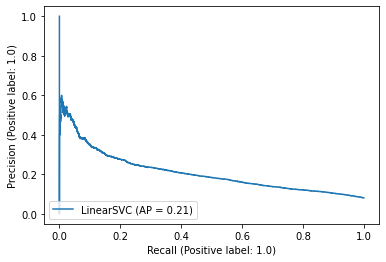

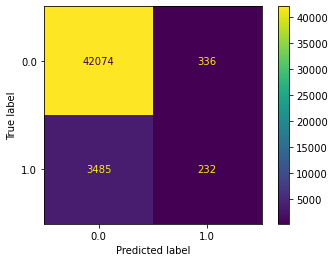

[01:18:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:18:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:18:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:18:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



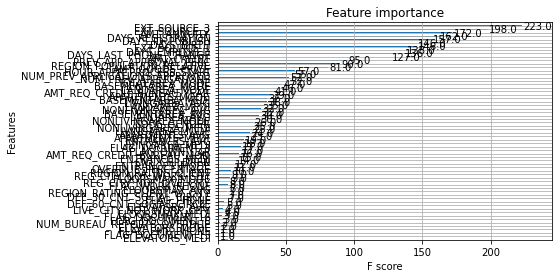

<Figure size 2880x864 with 0 Axes>

CPU times: user 5min 45s, sys: 2.48 s, total: 5min 48s
Wall time: 1min 37s


(None,
 None)

In [14]:
%%time
do_the_training_xgboost()

In [15]:
make_the_submission_file()

'Submission file created in working directory.'

In [16]:
def find_feature_importance(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test): 
    feature_import = xgb_clf.feature_importances_
    X_train_rank = X_train.columns
    X_train_rank = X_train_rank.to_frame()
    X_train_rank['Feature'] = X_train_rank
    X_train_rank['Import'] = feature_import
    X_train_rank.set_index('Feature', inplace = True)
    X_train_rank = X_train_rank.sort_values("Import", ascending = False)
    X_train_rank = X_train_rank.drop(0, axis = 1)
    global X_train_tuned_columns
    X_train_tuned_columns = X_train_rank[:30].T.columns
    new_X_train = X_train[X_train_tuned_columns]
    new_X_test = X_test[X_train_tuned_columns]
    return new_X_train, new_X_test
    

In [17]:
new_X_train, new_X_test = find_feature_importance()

#### Normal XGBoost, Hypertuning of features <a class="anchor" id="nxg_2"></a>

XGBoost model accuracy score: 0.9176
Below is the Precision Recall AUC score to give a better idea of how this unbalanced data is doing.


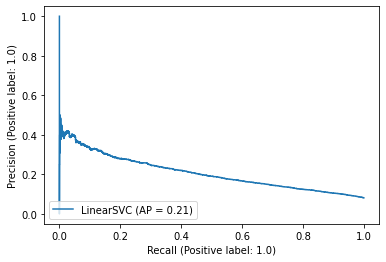

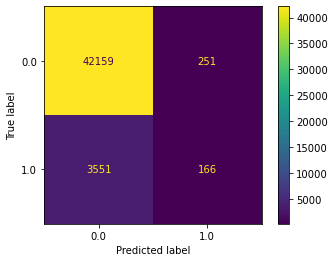

[01:19:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:19:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:19:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:19:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



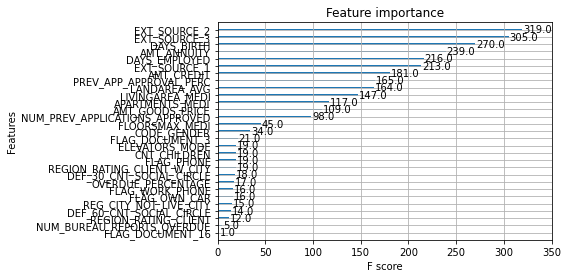

<Figure size 2880x864 with 0 Axes>

CPU times: user 3min 35s, sys: 1.29 s, total: 3min 37s
Wall time: 58.8 s


(None,
 None)

In [18]:
%%time

do_the_training_xgboost(X_train = new_X_train, X_test = new_X_test)

In [19]:
make_the_submission_file(hypertuned=True)

'Submission file created in working directory.'

In [20]:
def do_some_resampling(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, X=X, y=y, test_size = .15):
    X = X.reset_index() #resetting the index to help with the sampling
    y = y.reset_index()
    y.set_index('SK_ID_CURR', inplace = True) #Making sure y has correct dim
    X = X.fillna(X.mean()) #insert the mean for the NaNs
    X.set_index('SK_ID_CURR', inplace = True)#Making sure X has correct dim
    smote = SMOTE(sampling_strategy = 'auto',
                 random_state = 42,
                 n_jobs = -1)
    global X_sm, y_sm
    X_sm, y_sm = smote.fit_resample(X, y)
    X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(
                                        X_sm, y_sm, test_size=test_size, random_state=42)
    #return test dataset and the Xs and ys for training
    return X_sm_train, X_sm_test, y_sm_train, y_sm_test

In [21]:
X_sm_train, X_sm_test, y_sm_train, y_sm_test = do_some_resampling()

/Users/homefolder/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


#### SMOTE XGBoost, No Hypertuning of features <a class="anchor" id="sxg_1"></a>

XGBoost model accuracy score: 0.9522
Below is the Precision Recall AUC score to give a better idea of how this unbalanced data is doing.


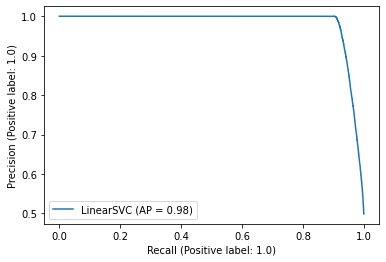

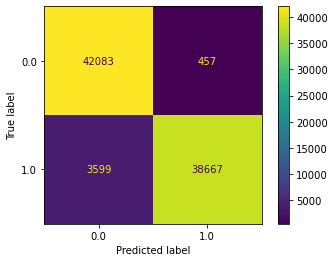

[01:22:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:22:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:22:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:22:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



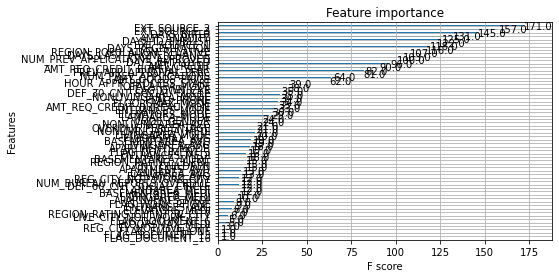

<Figure size 2880x864 with 0 Axes>

CPU times: user 18min 7s, sys: 7.48 s, total: 18min 14s
Wall time: 4min 59s


(None,
 None)

In [22]:
%%time

do_the_training_xgboost(X_train = X_sm_train, X_test = X_sm_test, y_train = y_sm_train, y_test = y_sm_test)

In [23]:
make_the_submission_file(run_type='smote')

'Submission file created in working directory.'

In [24]:
new_X_sm_train, new_X_sm_test = find_feature_importance(X_train = X_sm_train, X_test = X_sm_test, y_train = y_sm_train, y_test = y_sm_test)

#### SMOTE XGBoost, Hypertuning of features <a class="anchor" id="nxg_2"></a>

XGBoost model accuracy score: 0.9536
Below is the Precision Recall AUC score to give a better idea of how this unbalanced data is doing.


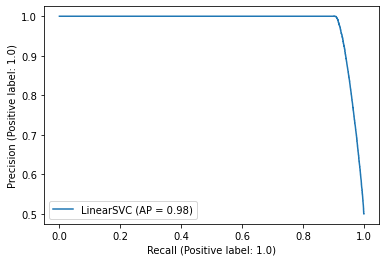

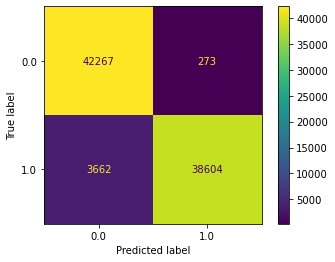

[01:26:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:26:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:26:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[01:26:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



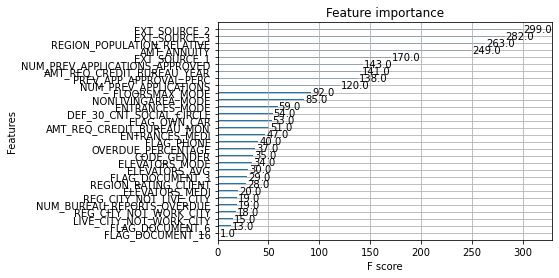

<Figure size 2880x864 with 0 Axes>

CPU times: user 9min 54s, sys: 3.27 s, total: 9min 58s
Wall time: 2min 38s


(None,
 None)

In [25]:
%%time

do_the_training_xgboost(X_train = new_X_sm_train, X_test = new_X_sm_test, y_train = y_sm_train, y_test = y_sm_test)

In [26]:
make_the_submission_file(run_type='smote', hypertuned = True)

'Submission file created in working directory.'

## Model Performance <a class="anchor" id="model_performance"></a>

Of the four different ways that we ran the XGBoost algorithm, the non-hypertuned, SMOTE model was the one that performed the best. It had a .98 AUC Precision Recall number despite it's above average accuracy scores. It seems like it would make sense that the best model could potentially run the longest. In this case, logic like this is right and our best performing model was also our slowest to run. Of course, the data did much better on the training set but we managed to pull off a Kaggle score of .56551 with our top model. In trying to up that number with the reduction the amount of data in the order of what is most important, it only got worse. 

## Results <a class="anchor" id="results"></a>

Based on what we found, it seems like past behaviour and the people that a customer hangs out around are two important, generalized variables for a model such as this. Over and over, we saw the scores from the different credit agencies be a leading indicator. Other popular features were the amount of previous loans, default history before, and how much the people and their things are worth.